# Air Quality Forecasting

## 1. Import necessary dependencies

Imports the necessary libraries and add src directory to the system path, allowing us to use our custom functions.

In [7]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('..')
from src.data_utils import load_and_prepare_data
from src.model_utils import (
    build_simple_lstm, train_model, evaluate_and_plot, 
    generate_submission, log_experiment, RMSECallback
)
sns.set_style('whitegrid')

## 2. Load and Prepare Data
We use our reusable function to load and clean the dataset in a single step.

In [8]:
TRAIN_FILE_PATH = '../data/train.csv'
X_train, y_train = load_and_prepare_data(TRAIN_FILE_PATH, is_train=True)

✅ Training data prepared successfully.


/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/notebooks/../src/data_utils.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['pm2.5'].fillna(df['pm2.5'].mean(), inplace=True)


## 3.Data Visualization

Before modeling, we'll visualize the target variable to understand its behavior over time and its distribution.

--- Descriptive Statistics ---


,pm2.5,DEWP,TEMP,PRES,Iws
count,28755.000000,30676.000000,30676.000000,30676.000000,30676.000000
mean,100.793427,-0.029431,-0.062712,0.013612,0.030542
std,93.144433,0.994087,1.015193,1.008991,1.018337
min,0.000000,-2.135153,-2.578070,-2.380821,-0.468688
25%,29.000000,-0.888034,-0.938521,-0.822670,-0.441894
50%,75.000000,-0.056622,0.045209,-0.043595,-0.352512
75%,142.000000,0.913358,0.864984,0.832865,0.005216
max,994.000000,1.814055,2.340578,2.877939,11.231956


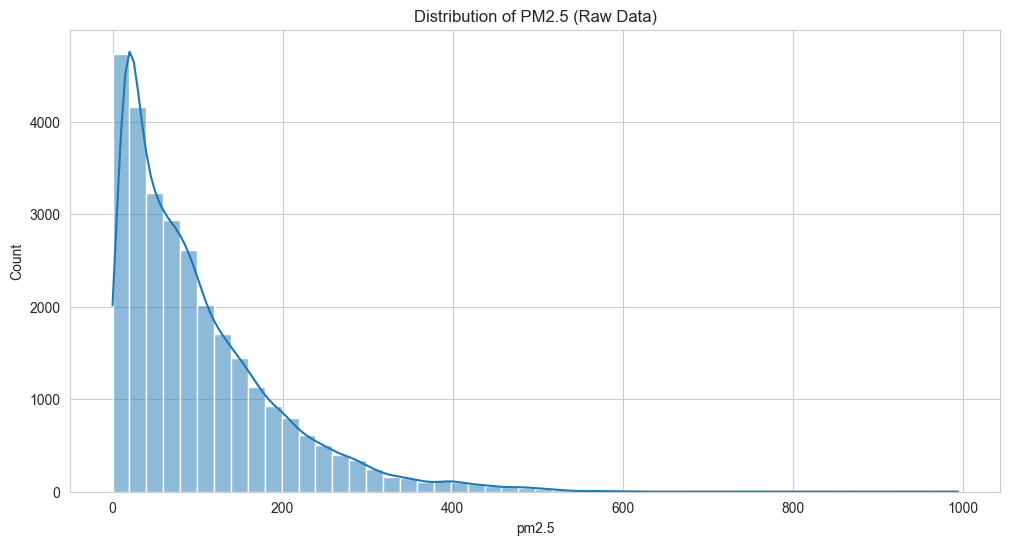

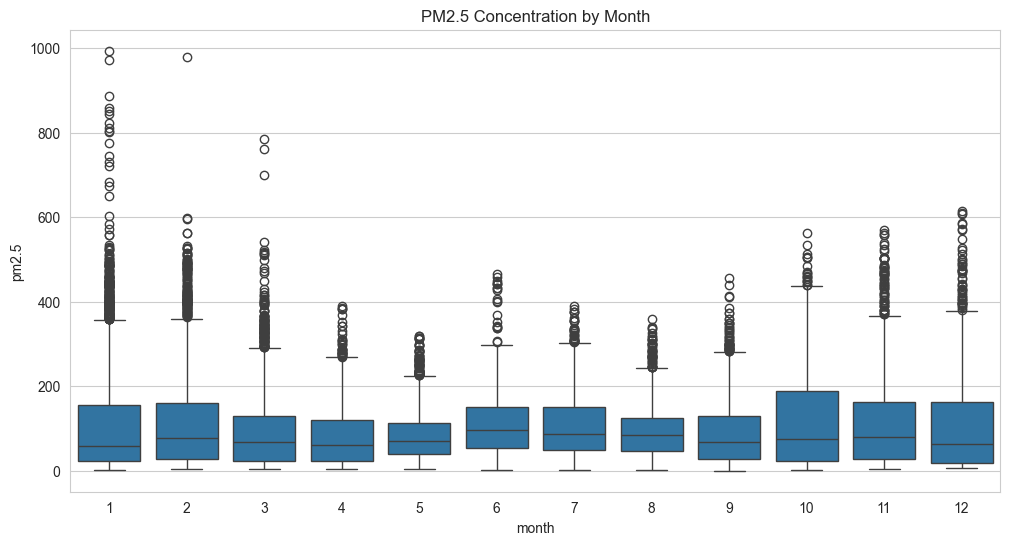

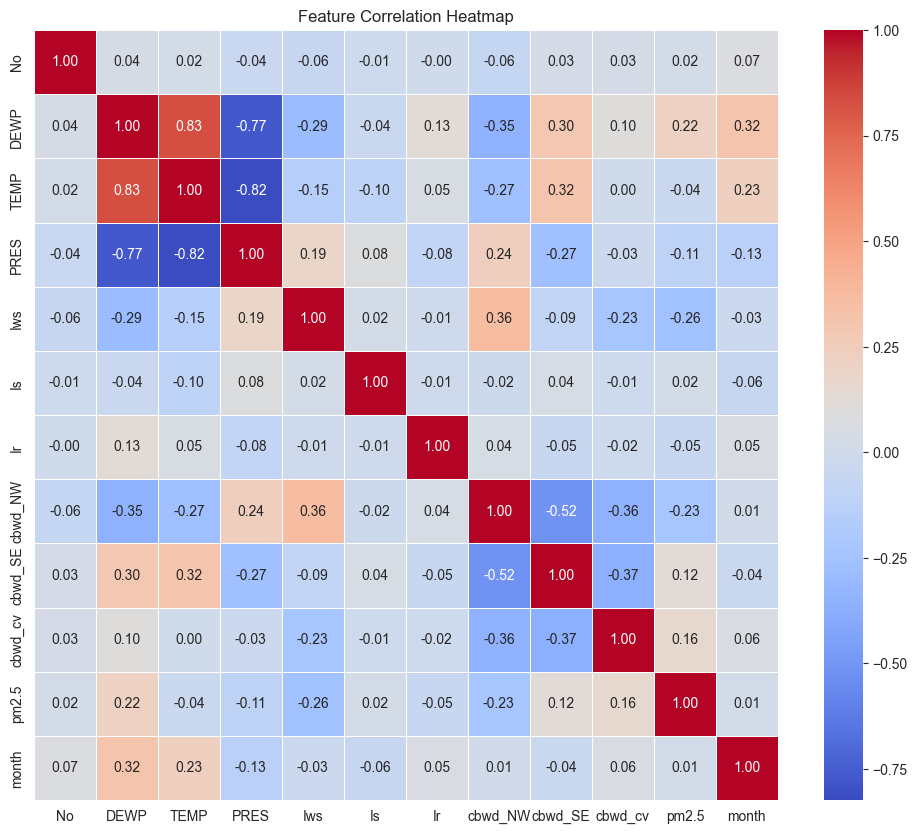

In [9]:
# For EDA, we'll reload the raw data to see original distributions
df_eda = pd.read_csv(TRAIN_FILE_PATH, index_col='datetime', parse_dates=True)

# Display descriptive statistics
print("--- Descriptive Statistics ---")
display(df_eda[['pm2.5', 'DEWP', 'TEMP', 'PRES', 'Iws']].describe())

# Visualize the pm2.5 distribution
plt.figure(figsize=(12, 6))
sns.histplot(df_eda['pm2.5'].dropna(), kde=True, bins=50)
plt.title('Distribution of PM2.5 (Raw Data)')
plt.show()

# Visualize pm2.5 by month to see seasonality
plt.figure(figsize=(12, 6))
df_eda['month'] = df_eda.index.month
sns.boxplot(x='month', y='pm2.5', data=df_eda)
plt.title('PM2.5 Concentration by Month')
plt.show()

# Visualize the correlation matrix
plt.figure(figsize=(12, 10))
correlation_matrix = df_eda.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Feature Correlation Heatmap')
plt.show()

## 4. Build and Train Model


In [10]:
MODEL_PATH = '../experiments/models/simple_lstm_baseline.keras'

# Build the model
input_shape = (X_train.shape[1], X_train.shape[2])
model = build_simple_lstm(input_shape)
model.summary()

# Train the model with the custom callback to show RMSE per epoch
# We pass the training data as the "validation_data" for the callback since there's no validation set
rmse_callback = RMSECallback(validation_data=(X_train, y_train))
history = model.fit(
    X_train, y_train,
    epochs=10,
    batch_size=32,
    callbacks=[rmse_callback],
    verbose=0 # Set to 0 to only see the custom callback output
)

# Save the model
model.save(MODEL_PATH)
print(f"\n✅ Model training complete. Model saved to: {MODEL_PATH}")

/Users/testsolutions/Documents/school/year3/term2/time-series-forecasting/tsf-repo/.venv/lib/python3.13/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,409 (21.13 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

 - val_rmse: 95.01
 - val_rmse: 84.74
 - val_rmse: 78.84
 - val_rmse: 76.00
 - val_rmse: 74.77
 - val_rmse: 74.22
 - val_rmse: 73.93
 - val_rmse: 73.78
 - val_rmse: 73.62
 - val_rmse: 73.51

✅ Model training complete. Model saved to: ../experiments/models/simple_lstm_baseline.keras


## Evaluate Model performance

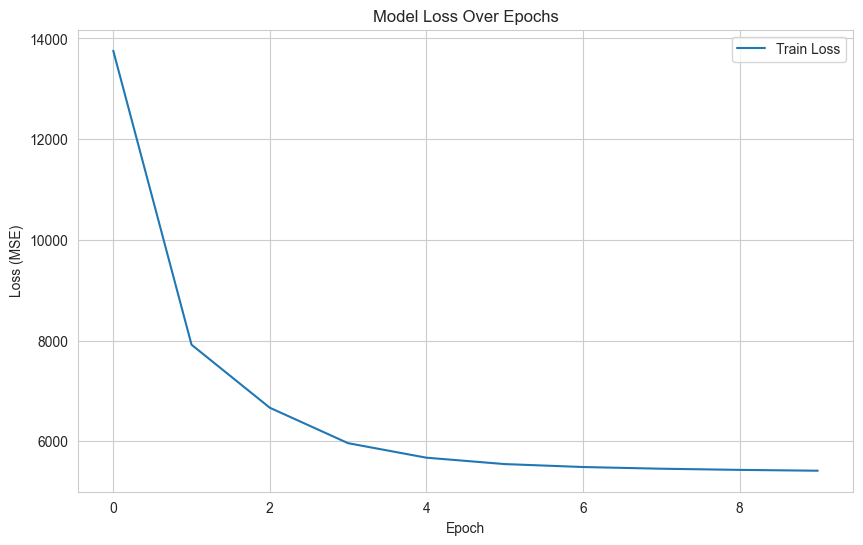

959/959 ━━━━━━━━━━━━━━━━━━━━ 0s 266us/step
--- Model Evaluation ---
✅ Final Training RMSE: 73.51


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 32)             │         5,376 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,229 (63.40 KB)

 Trainable params: 5,409 (21.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 10,820 (42.27 KB)

✅ Comprehensive experiment details logged to: ../experiments/metrics/01_simple_baseline_model_log.txt


In [11]:
evaluate_and_plot(history, model, X_train, y_train)

final_rmse = np.sqrt(model.evaluate(X_train, y_train, verbose=0))
experiment_parameters = {
    'exp_id': '01',
    'model_type': 'Simple LSTM Baseline',
    'sequence_length': X_train.shape[1],
    'batch_size': 32,
    'scaler_type': 'Mean Imputation (Unscaled Features)',
    'optimizer': 'adam',
    'notes': "This is the initial baseline model replicating the original notebook. No validation set was used."
}

LOG_PATH = f"../experiments/metrics/{experiment_parameters['exp_id']}_simple_baseline_model_log.txt"

log_experiment(
    model=model,
    history=history,
    rmse=final_rmse,
    log_path=LOG_PATH,
    **experiment_parameters
)

## 6. Generate Kaggle Submission
We use our trained model to generate the submission file


In [12]:
TEST_FILE_PATH = '../data/test.csv'
SUBMISSION_FILE_PATH = '../submissions/submission_simple_baseline.csv'

submission_df = generate_submission(MODEL_PATH, TEST_FILE_PATH, SUBMISSION_FILE_PATH)

print("\n--- Submission File Head ---")
display(submission_df.head())

✅ Test data prepared successfully.
411/411 ━━━━━━━━━━━━━━━━━━━━ 0s 356us/step
✅ Submission file created successfully at: ../submissions/submission_simple_baseline.csv

--- Submission File Head ---


,row ID,pm2.5
0,2013-07-02 4:00:00,89.291893
1,2013-07-02 5:00:00,89.919151
2,2013-07-02 6:00:00,81.347824
3,2013-07-02 7:00:00,69.290382
4,2013-07-02 8:00:00,55.179291
